Project Notebook - Plus X
==============================

@AI4ALL CMU 2022

TA: Huangyuan

This is the starter notebook for generic classification.  

Section Overview 
-----------------
- ✅ Importing dependencies
- ✅ Download Data
- ✅ Processing Data
- ✅ Constructing the CNN model
- ✅ Training the model
- ✅ Visualize model predictions
- ✅ Exporting the model

Importing Dependencies
----------------------

We will import a Github repository with some helper functions. We will also import a list of common Python dependencies. 

We are using Tensorflow / Keras as our default deep learning framework. 

In [1]:
# Clone a Github repository with helper functions
!pip install -q tensorflowjs
!pip install -q gdown
import gdown
import shutil

# Import a bunch of dependnecies
import string
import numpy as np
import pickle
import cv2
import os
from os import listdir
from PIL import Image
from scipy.ndimage.interpolation import rotate
from scipy.ndimage import gaussian_filter
from collections import defaultdict
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dropout

from keras import backend as K
K._get_available_gpus()

     |████████████████████████████████| 78 kB 3.1 MB/s 
     |████████████████████████████████| 1.0 MB 43.5 MB/s 
     |████████████████████████████████| 40 kB 2.8 MB/s 
     |████████████████████████████████| 511.7 MB 6.2 kB/s 
     |████████████████████████████████| 511.7 MB 4.4 kB/s 
     |████████████████████████████████| 5.8 MB 51.4 MB/s 
     |████████████████████████████████| 1.6 MB 55.0 MB/s 
     |████████████████████████████████| 438 kB 73.6 MB/s 
     |████████████████████████████████| 5.8 MB 50.7 MB/s 


['/device:GPU:0']

Download Data
------------

We define `load_data_google` functions. 

In [2]:
'''
The load_data_google downloads a zip file and extracts it. 

Args:
  google_drive_id: 
'''
def load_data_google(google_drive_id, output='ham1000.zip'):    
  if os.path.isfile(output):
    print('using cached', output)
  else:
    gdown.download(id=google_drive_id, output=output, quiet=False)

  output_dir = output.replace('.zip', '-dir')
  shutil.unpack_archive(output, '.')

In [ ]:
print('loading data... this will take a minute!')
load_data_google(google_drive_id='1h_lBRROEjoOML4sk59_Z4eLuvTfYMEGI', output='ham1000.zip')

loading data... this will take a minute!


Downloading...
From: https://drive.google.com/uc?id=1h_lBRROEjoOML4sk59_Z4eLuvTfYMEGI
To: /content/ham1000.zip
 63%|██████▎   | 1.11G/1.77G [00:06<00:03, 164MB/s]

Processing Data
---------------

We use `create_data_folder` and `augment_data` to visualize original data and augmented data with Keras dataloader. 

Define `augment_data` and `create_data_folder` functions. 

In [ ]:
'''
The augment_data method is a keras.Sequential method that contains
keras processing layers https://keras.io/guides/preprocessing_layers/
'''
augment_data = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

'''
The create_data_folder functions takes in a dataset folder and splits into train 
test set. 

Args:
  source_folder: source folder 
  target_folder: target folder

Source Folder Structure:
  source_folder/
    class_1/
      img1.jpg
      ...
    class_2/
    ...

Target Folder Structure:
  source_folder/
    train/
      class_1/
        img1.jpg
        ...
      ...
    test/
      ...
'''
def create_data_folder(source_folder, target_folder):
  shutil.rmtree(target_folder, ignore_errors=True)
  os.makedirs(target_folder, exist_ok=True)
  split_ratio = 0.8
  folder_list = os.listdir(source_folder)
  folder_list.sort()
  print(folder_list)
  for folder in folder_list:
    os.makedirs(target_folder + '/train/' + folder, exist_ok=True)
    os.makedirs(target_folder + '/test/' + folder, exist_ok=True)
    image_list = os.listdir(source_folder + '/' + folder)
    len_images = len(image_list)
    rand_idx = np.random.permutation(len_images)

    train_idx = rand_idx[:int(split_ratio*len_images)]
    test_idx = rand_idx[int(split_ratio*len_images):]
    print(folder, 'train:', len(train_idx), 'test:', len(test_idx))

    for idx in train_idx:
      image_addr = source_folder + '/' + folder + '/' + image_list[idx]
      target_addr = target_folder + '/train/' + folder + '/' + image_list[idx]
      shutil.copy(image_addr, target_addr)
    for idx in test_idx:
      image_addr = source_folder + '/' + folder + '/' + image_list[idx]
      target_addr = target_folder + '/test/' + folder + '/' + image_list[idx]
      shutil.copy(image_addr, target_addr)
  print('finished creating data folder', target_folder) 
create_data_folder('images/', 'dataset/')

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
akiec train: 142 test: 36
bcc train: 247 test: 62
bkl train: 518 test: 130
df train: 56 test: 15
mel train: 890 test: 223
nv train: 3142 test: 786
vasc train: 68 test: 18
finished creating data folder dataset/


Load datasets using Keras. 

In [ ]:
batch_size = 32
train_ds = keras.utils.image_dataset_from_directory(
    directory='dataset/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(128, 128))
test_ds = keras.utils.image_dataset_from_directory(
    directory='dataset/test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(128, 128))
n_classes = len(train_ds.class_names)
class_names = train_ds.class_names
print(class_names)

Found 5063 files belonging to 7 classes.
Found 1270 files belonging to 7 classes.
['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


Visualize dataset and augmentations. 

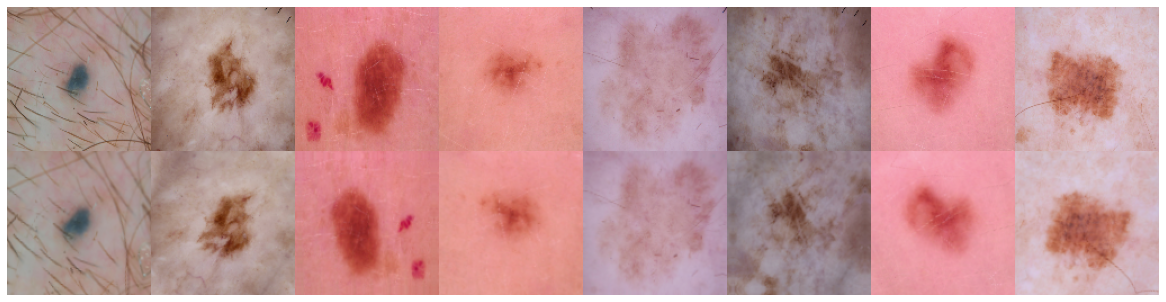

In [ ]:
# VISUALIZE ORIGINAL IMAGES ON TOP AND AUGMENTED ON BOTTOM
show_batch_size = 8
x_train, y_train = next(iter(train_ds))
x_train, y_train = x_train[:show_batch_size], y_train[:show_batch_size]


x_aug = augment_data(x_train)
show_images = np.hstack(x_train)/255.0
show_images_aug = np.hstack(x_aug)/255.0
vis = np.vstack((show_images, show_images_aug))

fig, ax = plt.subplots(figsize=plt.figaspect(vis))
fig.subplots_adjust(0,0,1,1)
ax.imshow(vis)
ax.axis('off')
plt.show()

Defining the CNN Model
-----------------------

We define a CNN model below. Think of it as adding layers to a sandwich. A sample model architecture is defined below. 


In [ ]:
x_train, y_train = next(iter(train_ds))
_, height, width, depth = x_train.shape
print(height, width, depth)
input_shape = (height, width, depth)
chanDim = -1

def get_model(name='simple'):
  if name == 'simple':
    model = keras.Sequential()
    # BLOCK 1
    model.add(layers.Conv2D(128, (3, 3), padding="same", activation="relu", input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.2))

    # BLOCK 2
    model.add(layers.Conv2D(256, (3, 3), padding="same", activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.2))

    # BLOCK 3
    model.add(layers.Conv2D(512, (3, 3), padding="same", activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.2))

    # BLOCK 4
    model.add(layers.Conv2D(1024, (3, 3), padding="same", activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.2))

    # CLASSIFIER
    model.add(layers.MaxPooling2D(pool_size=(8, 8)))

    model.add(layers.Flatten())
    # model.add(layers.Dense(n_classes, kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.L1(0.1)))
    model.add(layers.Dense(n_classes))

    model.add(Dropout(0.5))
    
    model.add(layers.Activation("softmax"))
    return model
    
  elif name == 'mobilenet':
    # ROBUST MOBILENET
    base_model = tf.keras.applications.MobileNet(input_shape=input_shape, include_top=False)
    base_model.trainable = True
    model = tf.keras.Sequential([
      base_model,
      keras.layers.GlobalAveragePooling2D(),
      keras.layers.Dense(n_classes, activation='softmax')
    ])
    return model

model = get_model('mobilenet')
model.summary()

128 128 3
17235968/17225924 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)                 7175      
                                                                 
Total params: 3,236,039
Trainable params: 3,214,151
Non-trainable params: 21,888
_________________________________________________________________


Training the CNN Model
----------------------

We split training into 4 code cells. 

1. Define training hyperparameters (epochs, batch_size, learning_rate)
2. Compile and call model.fit()
3. Plot training / testing accuracy plot

In [ ]:
# HYPERPARAMETRS

# num_epochs - number of times to repeat the training
num_epochs = 10

# batch_size - how many images to train together at each step
batch_size = 64

# learning_rate - the update speed of the network
learning_rate = 1e-4

In [ ]:
print("[INFO] training network...")
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              metrics=["accuracy"])
history = model.fit(train_ds.map(lambda x, y: (augment_data(x), y)), batch_size=batch_size,
                    validation_data=(test_ds),
                    epochs=num_epochs, verbose=1)

[INFO] training network...
Epoch 1/10
159/159 [==============================] - 43s 174ms/step - loss: 1.0478 - accuracy: 0.6344 - val_loss: 0.9498 - val_accuracy: 0.7094
Epoch 2/10
159/159 [==============================] - 29s 179ms/step - loss: 0.3606 - accuracy: 0.8825 - val_loss: 0.6621 - val_accuracy: 0.7756
Epoch 3/10
159/159 [==============================] - 27s 166ms/step - loss: 0.1525 - accuracy: 0.9688 - val_loss: 0.6357 - val_accuracy: 0.7913
Epoch 4/10
159/159 [==============================] - 27s 165ms/step - loss: 0.0768 - accuracy: 0.9897 - val_loss: 0.6376 - val_accuracy: 0.7937
Epoch 5/10
159/159 [==============================] - 27s 167ms/step - loss: 0.0519 - accuracy: 0.9925 - val_loss: 0.6127 - val_accuracy: 0.8000
Epoch 6/10
159/159 [==============================] - 28s 173ms/step - loss: 0.0330 - accuracy: 0.9970 - val_loss: 0.6615 - val_accuracy: 0.8008
Epoch 7/10
159/159 [==============================] - 28s 167ms/step - loss: 0.0279 - accuracy: 0.9964 

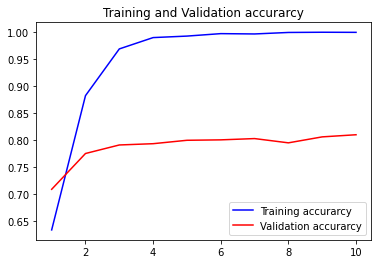

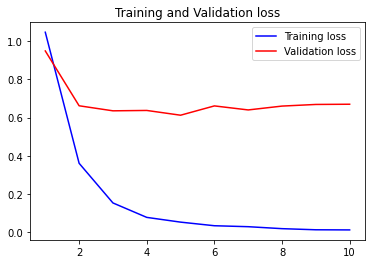

In [ ]:
  # PLOT GRAPH
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy 
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Visualizing Model Predictions
-----------------------------

We randomly visualize images from the test set and see the true label and predcited label. 

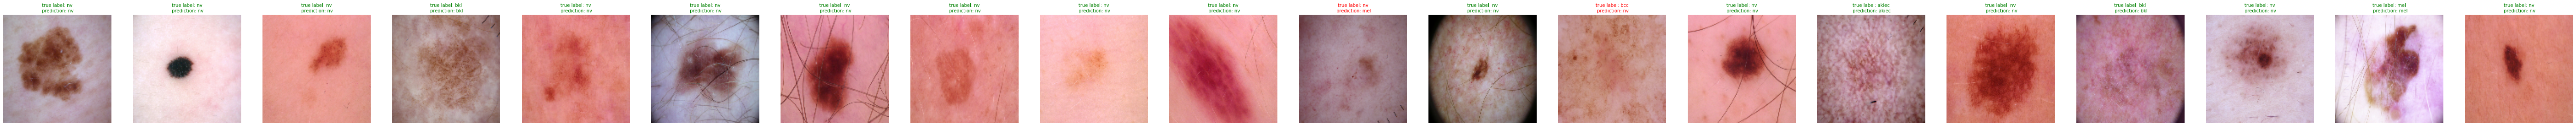

In [ ]:
show_batch_size = 20

x_test, y_test = next(iter(test_ds))
x_test = x_test[:show_batch_size]
y_test = y_test[:show_batch_size]
pred = model.predict(x_test)


fig, axes = plt.subplots(1, show_batch_size, figsize=(int(5*show_batch_size),5))

true_label = y_test.numpy().argmax(axis=1)
pred_label = pred.argmax(axis=1)
for i in range(show_batch_size):
  img = x_test[i]/255.0
  axes[i].axis("off")
  if true_label[i] == pred_label[i]:
    axes[i].set_title(f"true label: {train_ds.class_names[true_label[i]]}\n prediction: {train_ds.class_names[pred_label[i]]}", fontsize=10, color='green')
  else:
    axes[i].set_title(f"true label: {train_ds.class_names[true_label[i]]}\n prediction: {train_ds.class_names[pred_label[i]]}", fontsize=10, color='red')
  axes[i].imshow(img)

Saving and Exporting the Model
------------------------------

We save the model and export to tensorflow js. See deploying image classification CNN slides for a tutorial. 

Convert model to tfjs. 

In [ ]:
tfjs_target_dir = 'model_tfjs'
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, tfjs_target_dir)

Zip the model tfjs folder for download. 

In [ ]:
!zip -r model_tfjs_export.zip model_tfjs

  adding: model_tfjs/ (stored 0%)
  adding: model_tfjs/group1-shard2of4.bin (deflated 7%)
  adding: model_tfjs/model.json (deflated 94%)
  adding: model_tfjs/group1-shard3of4.bin (deflated 7%)
  adding: model_tfjs/group1-shard4of4.bin (deflated 7%)
  adding: model_tfjs/group1-shard1of4.bin (deflated 7%)


Generate dataset collage image. 

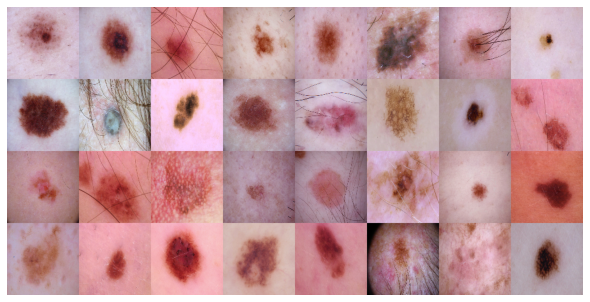

In [ ]:
# GENERATE A BIG IMAGE FOR THE WEBSITE
show_row = 4
show_col = 8
show_batch_size = show_row*show_col
x_train, y_train = next(iter(test_ds))
x_train, y_train = x_train[:show_batch_size], y_train[:show_batch_size]

rows = []
for r in range(show_row):
  row_rgb = np.hstack(x_train[r*show_col:r*show_col+show_col])/255.
  rows.append(row_rgb)
vis = np.vstack(rows)

fig, ax = plt.subplots(figsize=plt.figaspect(vis))
fig.subplots_adjust(0,0,1,1)
ax.imshow(vis)
ax.axis('off')

# plt.imsave('dataset.jpg', vis)
plt.savefig('dataset.jpg')
plt.show()